# Testing setBLP.jl

## Packages

In [1]:
import LinearAlgebra ,Base

In [2]:
using Plots

## Structures and related functions

#### Vertex

In [3]:
mutable struct Vertex
    v::Vector{Real}
end

In [ ]:
function subVertex(v1::Vertex,v2::Vertex)
    return  Vertex(v1.v-v2.v)
end

Base.:(-)(v1::Vertex,v2::Vertex) = Vertex(v1.v-v2.v)

function addVertex(v1::Vertex,v2::Vertex)
    return Vertex(v1.v+v2.v)
end

Base.:(+)(v1::Vertex,v2::Vertex) = Vertex(v1.v+v2.v)

In [8]:
function xangle(p1::Vertex,p2::Vertex)
    Δ = (p2-p1).v
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 2 methods)

In [9]:
function fetchY(ver::Vertex)
    return ver.v[2]
end

function fetchX(ver::Vertex)
    return ver.v[1]
end

fetchY (generic function with 1 method)

#### Segment

In [4]:
mutable struct Segment
    p1::Vertex
    p2::Vertex
    checkInput::Function
    length::Function
    dim::Function

    
    function Segment(p1,p2)
        this = new()

        this.p1 = p1
        this.p2 = p2

        this.checkInput = function()
            return size(this.p1) == size(this.p2)       
        end

        this.length = function()
            return norm(this.p1-this.p2)
        end

        this.dim = function()
            if this.checkInput()
                return length(this.p1)
            else
                return false
            end
        end

        return this        
    end
end


In [6]:

function dotDist(p::Vector{<:Real}, segment::Segment) 
    if segment.checkInput()
        if length(p) == segment.dim()
            p1_p2 = segment.p1 -segment.p2
            p_p2 = p -segment.p2

            λ = dot(p1_p2,p_p2)/dot(p1_p2,p1_p2)
            λ = max(min(λ,1),0)

            p0 = λ*segment.p1 + (1-λ)*segment.p2 

            return norm(p-p0)
        else
            return "dimention of p doesnt match dimention of segment"
        end
    else
        return "Segment has wrong dimentions"
    end
end


dotDist (generic function with 1 method)

In [7]:
function xangle(seg::Segment)
    Δ = seg.p2-seg.p1
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 1 method)

#### Polygon

In [5]:
mutable struct Polygon
    vertices :: Vector{Vertex}
    sort :: Function

    function Polygon(vertices)
        this = new()

        this.vertices=vertices
        this.sort = function()
            n=length(this.vertices)
            #step 1: find the point with a minimal y coordinate and put it first.
            # comment: sorting is complexity nlog(n) but the following is just n
            #using sorting:
            #I = sortperm(fetchY.(this.vertices))
            #this.vertices = this.vertices[I]
            #going over the list
            m=fetchY(this.vertices[1])
            for i=2:n
                l=fetchY(this.vertices[i])
                if l<m #then swap
                    m=l
                    temp=this.vertices[i]
                    this.vertices[i]=this.vertices[1]
                    this.vertices[1]=temp
                end
            end
            #step 2: compute angles between the minimal vertex and all other vertices
            angs =zeros(n)
            angs[1]=-1
            v1 =this.vertices[1]
            for i=2:n
                angs[i] = xangle(v1,this.vertices[i])
            end
            #step 3: sort by angle
            I=sortperm(angs)
            this.vertices=this.vertices[I]   
        end
        return this
    end
end

In [ ]:
function minkowskiSum(P::Polygon,Q::Polygon)
    # Computes the minkowski sum of two convex polygons: P and Q. The polygons
    # are represented by their vertices and are ordered counter clockwise such
    #* that the first vertex will be the one who has the smallest Y coordinate
    # (and smallest X coordinate in case of a tie).  This assumption is maintained
    # in twoDproj by conditions in BLPcalculator.
    
    m = length(P.vertices)
    n = length(Q.vertices)
    
    # It is important that the P polygon will end with the largest angle and 
    # not the Q polygon. That means that we need to look at the last vertex of P and
    # the last vertex of Q and compare the angle that each creates with the 
    # first vertex of the corresponding polygon. These angles are denoted as
    # angP and angQ. If angP < angQ then we need to switch the order.
    
    local tol=1e-10
    angP = xangle(P.vertices[1],P.vertices[m])
    angQ = xangle(Q.vertices[1],Q.vertices[m]) 
    
end

#Base.:(+)(P::Polygon,Q::Polygon) = minkowskiSum(P,Q)

## Testing

In [10]:
v4=Vertex([0,0])
v2=Vertex([1,0])
v3=Vertex([2,2])
v1=Vertex([-0.5,0.6])
pol = Polygon([v1,v2,v3,v4])

Polygon(Vertex[Vertex(Real[-0.5, 0.6]), Vertex(Real[1, 0]), Vertex(Real[2, 2]), Vertex(Real[0, 0])], var"#7#8"{Polygon}(Polygon(#= circular reference @-2 =#)))

In [11]:
pol.sort();

In [12]:
n=length(pol.vertices)

4

In [13]:
x=zeros(n+1); y=zeros(n+1);
for i=1:n
    x[i]=pol.vertices[i].v[1]
    y[i]=pol.vertices[i].v[2]
end
x[n+1]=pol.vertices[1].v[1]
y[n+1]=pol.vertices[1].v[2]

0

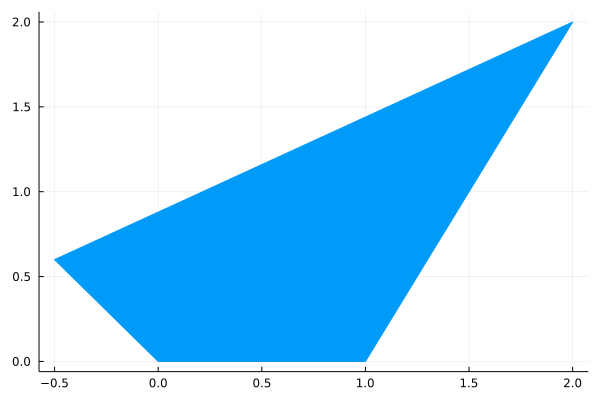

In [14]:
plot(x,y,label="",fill=true)